In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aggregated-week-max/aggregated_week_max.csv


In [3]:
!pip install darts==0.24.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 17.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 68.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet, Theta, FFT
from darts.metrics import mape, rmse

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:
# Load data
df = pd.read_csv("/kaggle/input/aggregated-week-max/aggregated_week_max.csv")
df['Date Time'] = pd.to_datetime(df['Date Time'])
df.head()

# /kaggle/input/aggregated-week-max/aggregated_week_max.csv

,Date Time,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)
0,2004-01-04,289.22,97.5,8.98,742.66,1471.04
1,2004-01-11,299.10,99.0,18.91,838.63,1691.12
2,2004-01-18,285.21,97.7,9.31,280.89,534.56
3,2004-01-25,278.27,98.6,6.55,401.61,764.09
4,2004-02-01,283.74,97.3,8.48,449.90,878.96


In [31]:
train_data = df[["Date Time", "Tpot (K)"]].head(len(df)-60)
test_data = df[["Date Time", "Tpot (K)"]].tail(60)
train_data = train_data.set_index("Date Time")
test_data = test_data.set_index("Date Time")
# display(train_data.head())
# display(train_data.tail())
# display(test_data.head())
# display(test_data.tail())

,Tpot (K)
Date Time,
2004-01-04,289.22
2004-01-11,299.10
2004-01-18,285.21
2004-01-25,278.27
2004-02-01,283.74


,Tpot (K)
Date Time,
2019-10-13,299.34
2019-10-20,300.22
2019-10-27,294.76
2019-11-03,282.89
2019-11-10,302.03


,Tpot (K)
Date Time,
2019-11-17,283.56
2019-11-24,283.77
2019-12-01,286.98
2019-12-08,298.76
2019-12-15,296.36


,Tpot (K)
Date Time,
2020-12-06,300.94
2020-12-13,306.34
2020-12-20,284.93
2020-12-27,288.75
2021-01-03,280.96


In [33]:
# Create TimeSeries objects
series = TimeSeries.from_dataframe(df, 'Date Time', 'Tpot (K)')

# Shift all values to be strictly positive
data_columns = df.columns.drop('Date Time')
shifts = df[data_columns].min() + 1
df_shifted = df.copy()
df_shifted[data_columns] = df[data_columns] + shifts

# Scale the data
scaler_uni = MinMaxScaler(feature_range=(0.1, 1.1))
series_shifted_scaled = TimeSeries.from_times_and_values(series.time_index,
                                                         scaler_uni.fit_transform(df_shifted['Tpot (K)'].values.reshape(-1, 1)).reshape(-1))


# Train and test sets
train, test = series_shifted_scaled.split_before(pd.Timestamp('2019-11-17'))
test_original = series.split_before(pd.Timestamp('2019-11-17'))[1] # Keep a copy of original test set

# List of models to try
models = [ExponentialSmoothing(), ARIMA(1,1,1), Prophet(), Theta(), FFT()]

# Univariate forecasting
results = []
for model in models:
    model.fit(train)
    forecast = model.predict(len(test))
    # Reverse scaling and shift
    forecast = TimeSeries.from_times_and_values(forecast.time_index,
                                                scaler_uni.inverse_transform(forecast.values().reshape(-1, 1)).reshape(-1) - shifts['Tpot (K)'])
    results.append((str(model), rmse(test_original, forecast), mape(test_original, forecast)))
    test_data[str(model)] = forecast.values()

# Print results
print("Univariate:")
for result in results:
    print(f"{result[0]} RMSE: {result[1]} MAPE: {result[2]}")


15:13:46 - cmdstanpy - INFO - Chain [1] start processing
15:13:46 - cmdstanpy - INFO - Chain [1] done processing


Univariate:
ExponentialSmoothing() RMSE: 6.5383795582705675 MAPE: 1.7187447358773245
ARIMA(p=1, q=1) RMSE: 7.902304460513391 MAPE: 2.2025491194443862
Prophet() RMSE: 6.4785379887504915 MAPE: 1.7964050024764349
Theta() RMSE: 8.151637607502877 MAPE: 2.297083079604437
FFT() RMSE: 7.147246108518343 MAPE: 1.8751744691139494


In [28]:
display(test_data.head(1))

,Tpot (K),ExponentialSmoothing(),"ARIMA(p=1, q=1)",Prophet(),Theta(),FFT()
Date Time,,,,,,
2019-11-17,283.56,286.048031,298.465293,292.460095,295.52952,291.533889


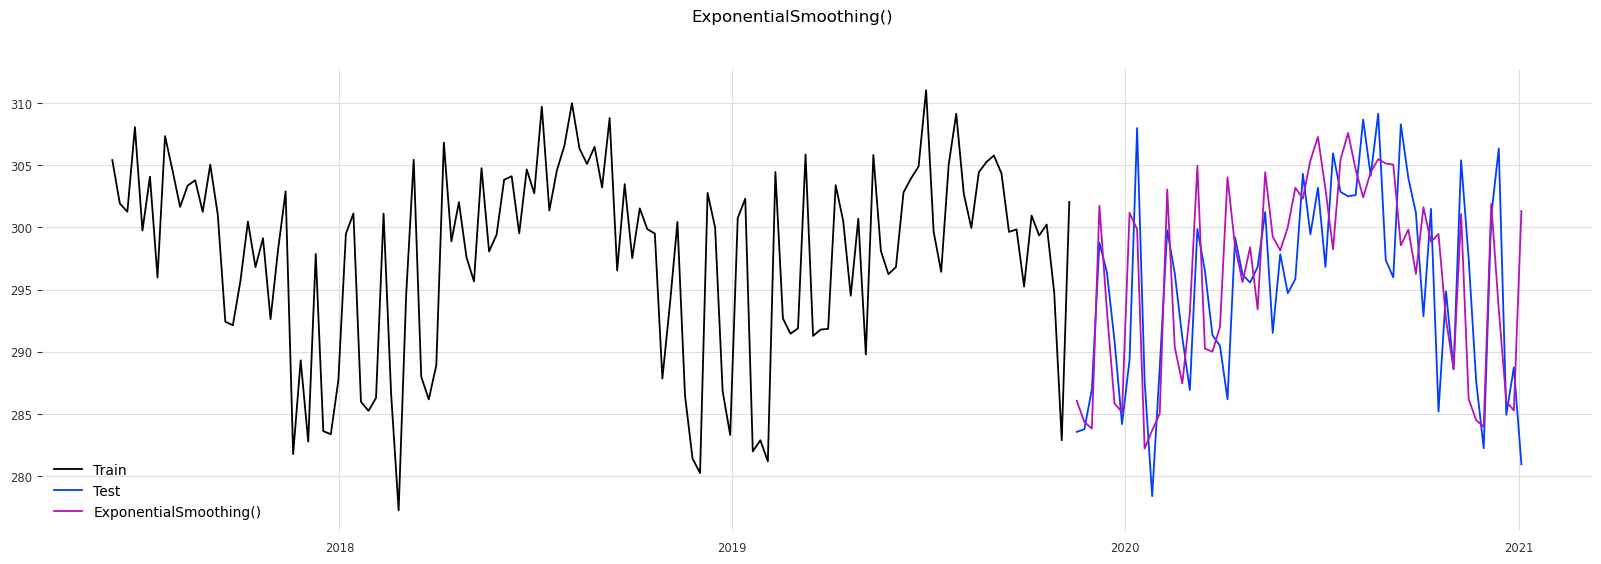

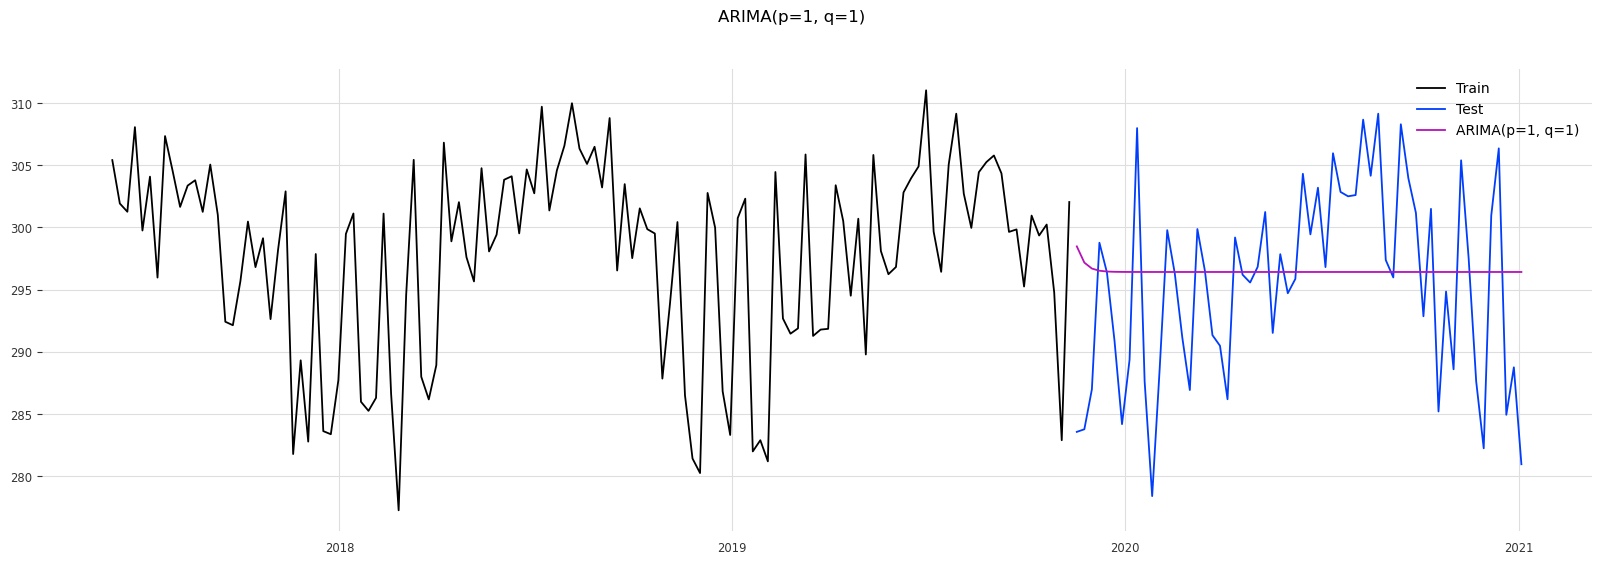

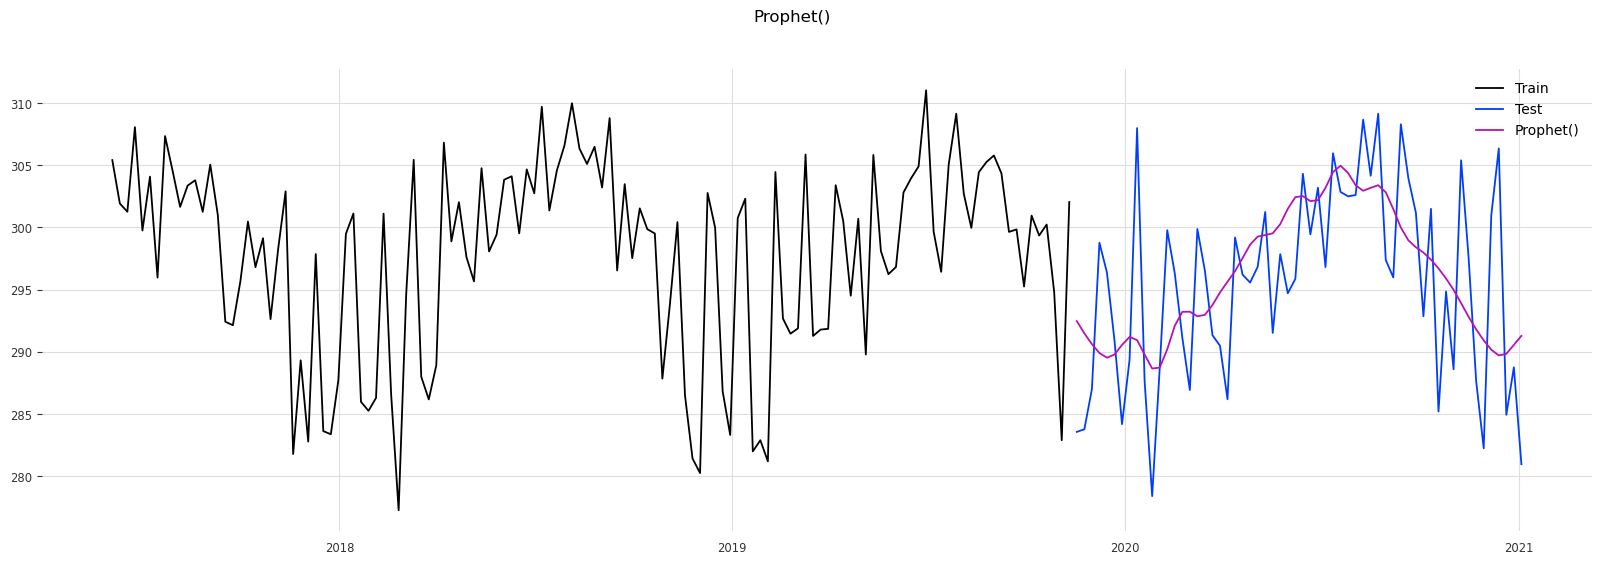

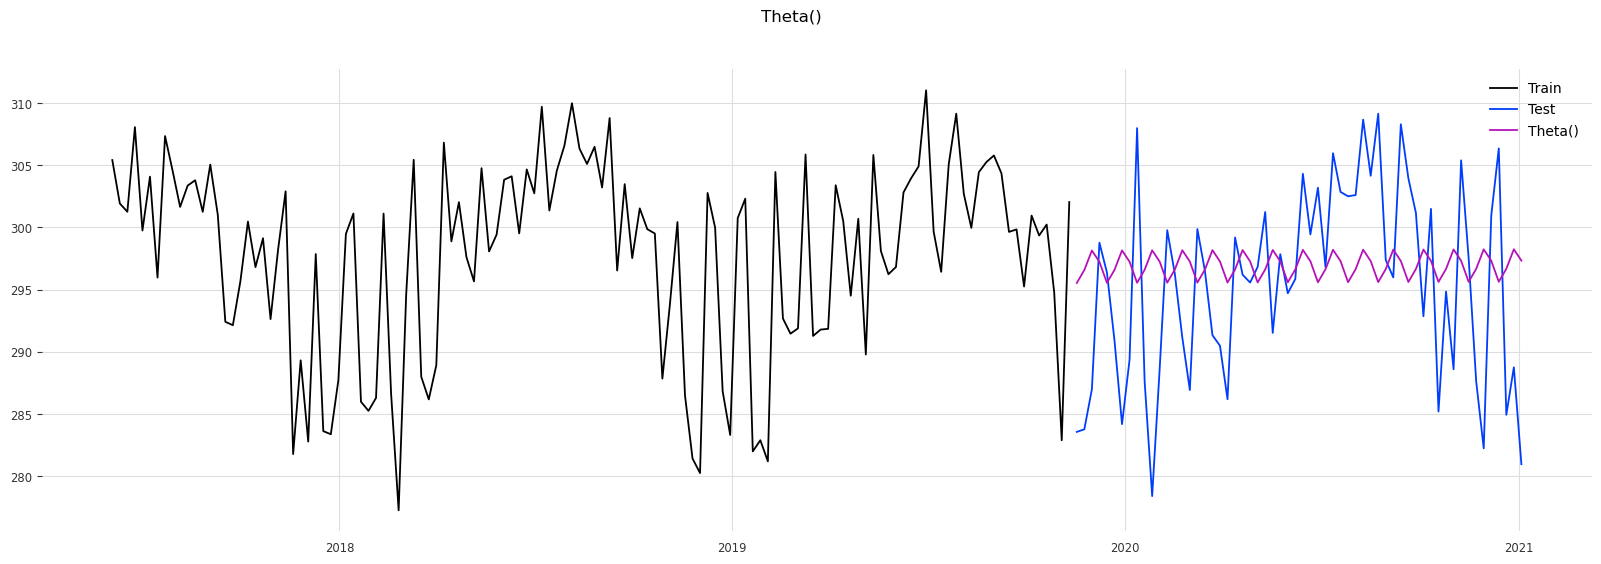

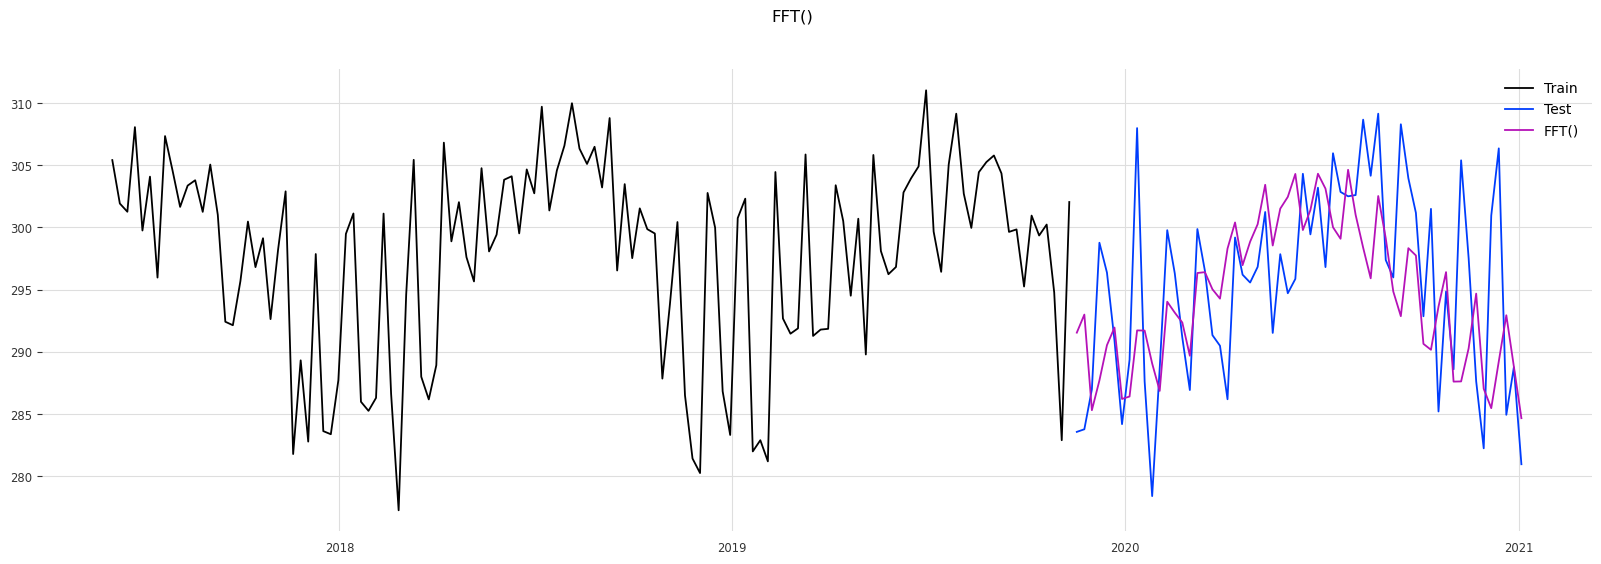

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot results
for result in results:
    model_name = result[0]
#     plt.figure(figsize=(40, 6))
#     train_data[-128:].plot(label='Train data ')
#     test_data["Tpot (K)"].plot(label='Test data')
#     test_data[model_name].plot(label=model_name+' Forecast')
#     plt.title(model_name)
#     plt.legend(loc = 'best')
#     plt.show(block = False)
    
    plt.figure(figsize=(20, 6))
    plot_title = model_name
    plt.plot(train_data[-128:], label='Train')
    plt.plot(test_data['Tpot (K)'], label='Test')
    plt.plot(test_data[model_name], label=plot_title)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.legend(loc='best')
    plt.suptitle(plot_title) # add a title
    plt.savefig("{}.png".format(plot_title.replace("/", " per ").replace("**", "^"))) # save the figure
    plt.show(block = False)


## MultiVariate Implementation



In [38]:
# Multivariate forecasting
from darts.models import BlockRNNModel

In [40]:
train_multi_plot = df[["Date Time", "Tpot (K)"]].head(len(df)-60)
test_multi_plot = df[["Date Time", "Tpot (K)"]].tail(60)
train_multi_plot = train_multi_plot.set_index("Date Time")
test_multi_plot = test_multi_plot.set_index("Date Time")

In [41]:
# Create TimeSeries objects for multivariate data
series_multivariate = TimeSeries.from_dataframe(df, 'Date Time')

shifts

# Shift all values in the multivariate series to be strictly positive
df_shifted_multivariate = df.copy()
df_shifted_multivariate[data_columns] = df[data_columns] + shifts
df_shifted_multivariate.head()

,Date Time,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)
0,2004-01-04,561.32,181.2,13.49,834.81,1671.65
1,2004-01-11,571.20,182.7,23.42,930.78,1891.73
2,2004-01-18,557.31,181.4,13.82,373.04,735.17
3,2004-01-25,550.37,182.3,11.06,493.76,964.70
4,2004-02-01,555.84,181.0,12.99,542.05,1079.57


In [42]:
# Scale the data
scaler_multi = MinMaxScaler(feature_range=(0.1, 1.1))
df_shifted_scaled_multivariate = df_shifted_multivariate.copy()
df_shifted_scaled_multivariate[data_columns] = scaler_multi.fit_transform(df_shifted_multivariate[data_columns])
series_multivariate_shifted_scaled = TimeSeries.from_dataframe(df_shifted_scaled_multivariate, 'Date Time')
display(df_shifted_scaled_multivariate.head())
print(series_multivariate_shifted_scaled)

,Date Time,Tpot (K),rh (%),H2OC (mmol/mol),SWDR (W/m²),PAR (µmol/m²/s)
0,2004-01-04,0.550298,0.955491,0.316120,0.677493,0.677416
1,2004-01-11,0.795825,1.042197,0.708455,0.762560,0.777365
2,2004-01-18,0.450646,0.967052,0.329158,0.268184,0.252117
3,2004-01-25,0.278181,1.019075,0.220111,0.375189,0.356357
4,2004-02-01,0.414115,0.943931,0.296365,0.417993,0.408525


<TimeSeries (DataArray) (Date Time: 888, component: 5, sample: 1)>
array([[[0.55029821],
        [0.95549133],
        [0.31612011],
        [0.67749275],
        [0.67741618]],

       [[0.79582505],
        [1.04219653],
        [0.70845516],
        [0.76255972],
        [0.77736486]],

       [[0.45064612],
        [0.96705202],
        [0.32915844],
        [0.26818387],
        [0.25211655]],

       ...,

       [[0.44368787],
        [1.1       ],
        [0.36748321],
        [0.28073517],
        [0.26177172]],

       [[0.53861829],
        [1.1       ],
        [0.49352035],
        [0.29513903],
        [0.27344784]],

       [[0.34502982],
        [1.1       ],
        [0.2604109 ],
        [0.25540211],
        [0.23105775]]])
Coordinates:
  * Date Time  (Date Time) datetime64[ns] 2004-01-04 2004-01-11 ... 2021-01-03
  * component  (component) object 'Tpot (K)' 'rh (%)' ... 'PAR (µmol/m²/s)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None


In [43]:
# Train and test sets for multivariate series
train_multivariate, test_multivariate = series_multivariate_shifted_scaled.split_before(pd.Timestamp('2019-11-17'))
test_multivariate_original = series_multivariate.split_before(pd.Timestamp('2019-11-17'))[1] # Keep a copy of original test set for multivariate series

# print("train_multivariate:\n",train_multivariate)
# print("test_multivariate:\n",test_multivariate)

In [52]:
results_multivariate = []
input_chucks = [60, 120, 180, 240, 300, 360, 420]
# input_chucks = [60]
for icl in input_chucks:
    # Multivariate forecasting
    # List of multivariate models to try
    models_multivariate = [BlockRNNModel(input_chunk_length=icl, output_chunk_length=60)]
    
    for model in models_multivariate:
        model.fit(train_multivariate)
        forecast_multivariate = model.predict(n=len(test_multivariate))
        # Reverse scaling for all columns
        forecast_multivariate_df = forecast_multivariate.pd_dataframe()
        forecast_multivariate_df[data_columns] = scaler_multi.inverse_transform(forecast_multivariate_df[data_columns])
        # Shift all columns
        for column in data_columns:
            forecast_multivariate_df[column] -= shifts[column]
        forecast_multivariate = TimeSeries.from_dataframe(forecast_multivariate_df)
        results_multivariate.append((str(model), rmse(test_multivariate_original, forecast_multivariate), mape(test_multivariate_original, forecast_multivariate)))
#         print(type(forecast_multivariate.values()))
#         print(forecast_multivariate.values()[:,0])
        test_multi_plot[str("BlockRNN_input_"+ str(icl))] = forecast_multivariate.values()[:,0]


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [53]:
# Print results
print("Multivariate:")
for result in results_multivariate:
    print(f"{result[0]} RMSE: {result[1]} MAPE: {result[2]}")

Multivariate:
BlockRNNModel(input_chunk_length=60, output_chunk_length=60) RMSE: 91.19880373382323 MAPE: 12.586219509370943
BlockRNNModel(input_chunk_length=120, output_chunk_length=60) RMSE: 92.50117566799938 MAPE: 12.822819001199184
BlockRNNModel(input_chunk_length=180, output_chunk_length=60) RMSE: 98.4278829380921 MAPE: 13.698784194392811
BlockRNNModel(input_chunk_length=240, output_chunk_length=60) RMSE: 95.0970592642233 MAPE: 13.413086491392159
BlockRNNModel(input_chunk_length=300, output_chunk_length=60) RMSE: 110.42779495408845 MAPE: 15.409664672945533
BlockRNNModel(input_chunk_length=360, output_chunk_length=60) RMSE: 119.31202327935175 MAPE: 16.74839160142043
BlockRNNModel(input_chunk_length=420, output_chunk_length=60) RMSE: 130.94037707727722 MAPE: 19.277915648443393


In [54]:
display(test_multi_plot.head())

,Tpot (K),BlockRNN_input_60,BlockRNN_input_120,BlockRNN_input_180,BlockRNN_input_240,BlockRNN_input_300,BlockRNN_input_360,BlockRNN_input_420
Date Time,,,,,,,,
2019-11-17,283.56,295.701556,295.394837,295.993959,295.153312,296.434828,293.727015,294.929705
2019-11-24,283.77,286.537254,284.899402,286.966778,286.630560,289.119760,290.494356,294.544863
2019-12-01,286.98,287.041123,287.813548,287.966949,288.883021,288.477302,291.505119,294.092003
2019-12-08,298.76,295.436410,296.992318,295.683567,296.072422,294.740266,293.561209,292.484628
2019-12-15,296.36,296.134832,296.400621,295.609618,295.919137,294.161542,294.082679,293.351332


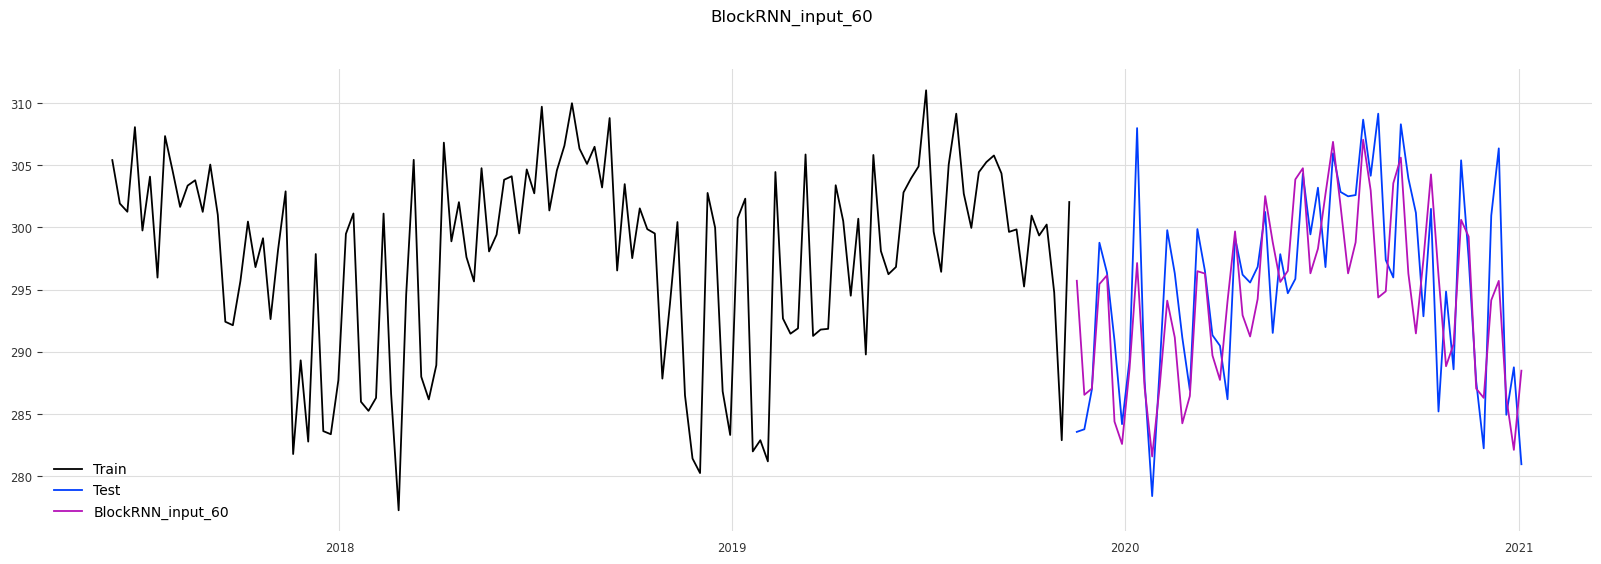

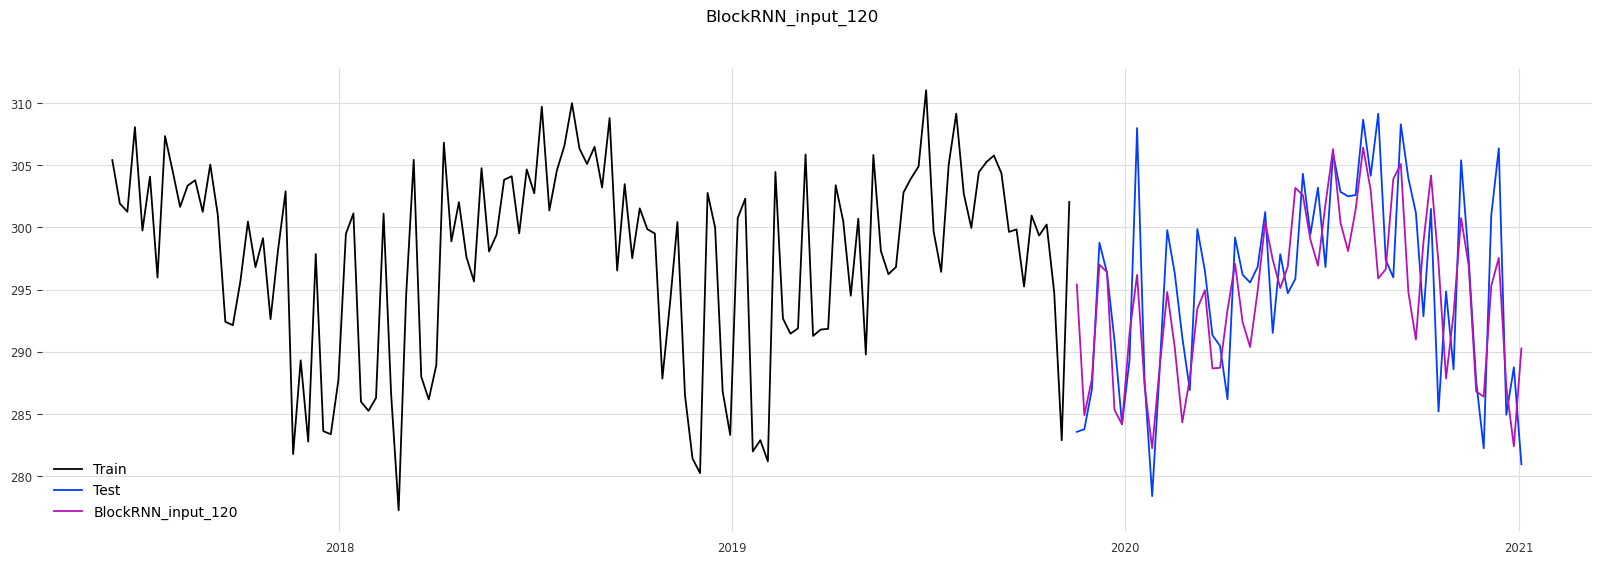

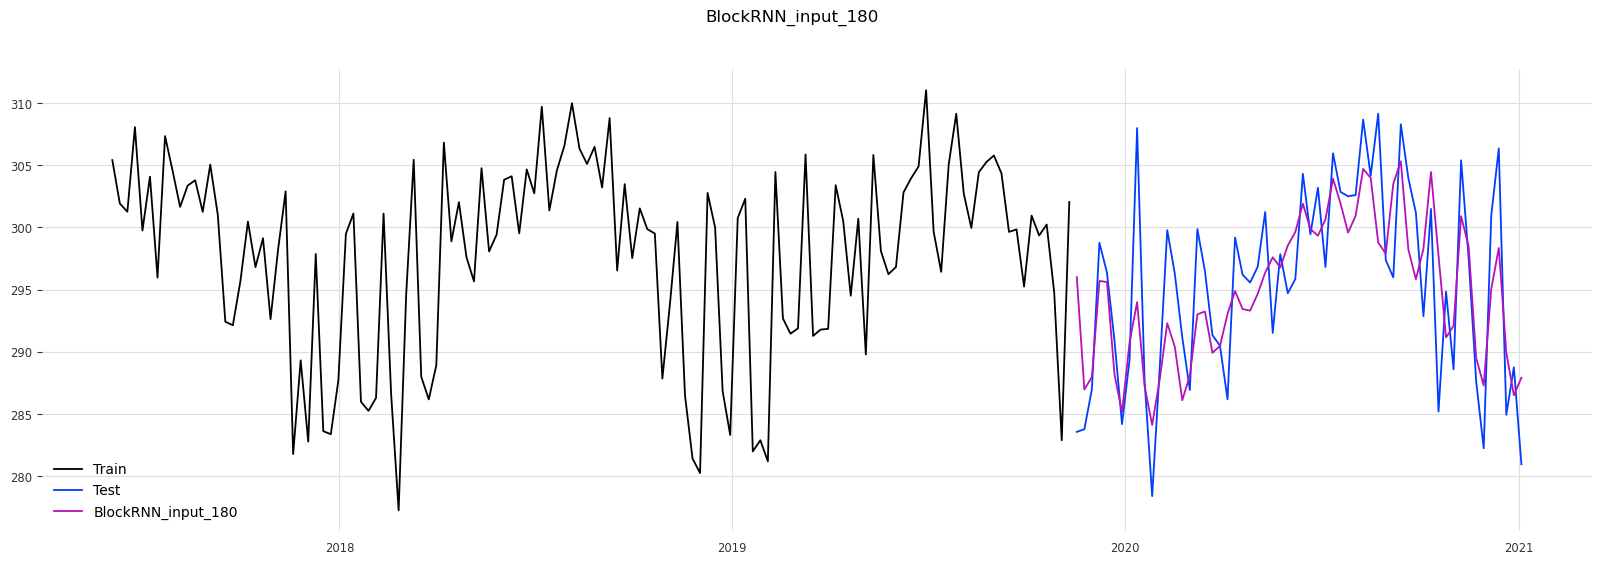

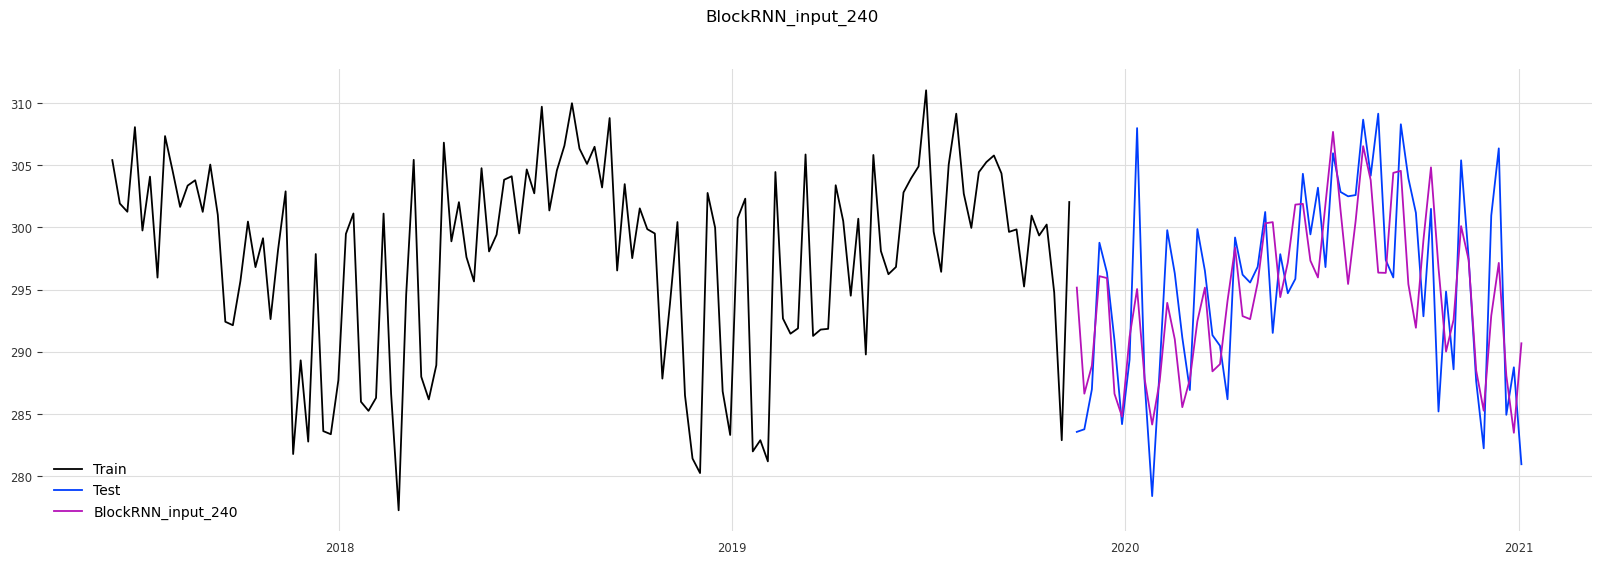

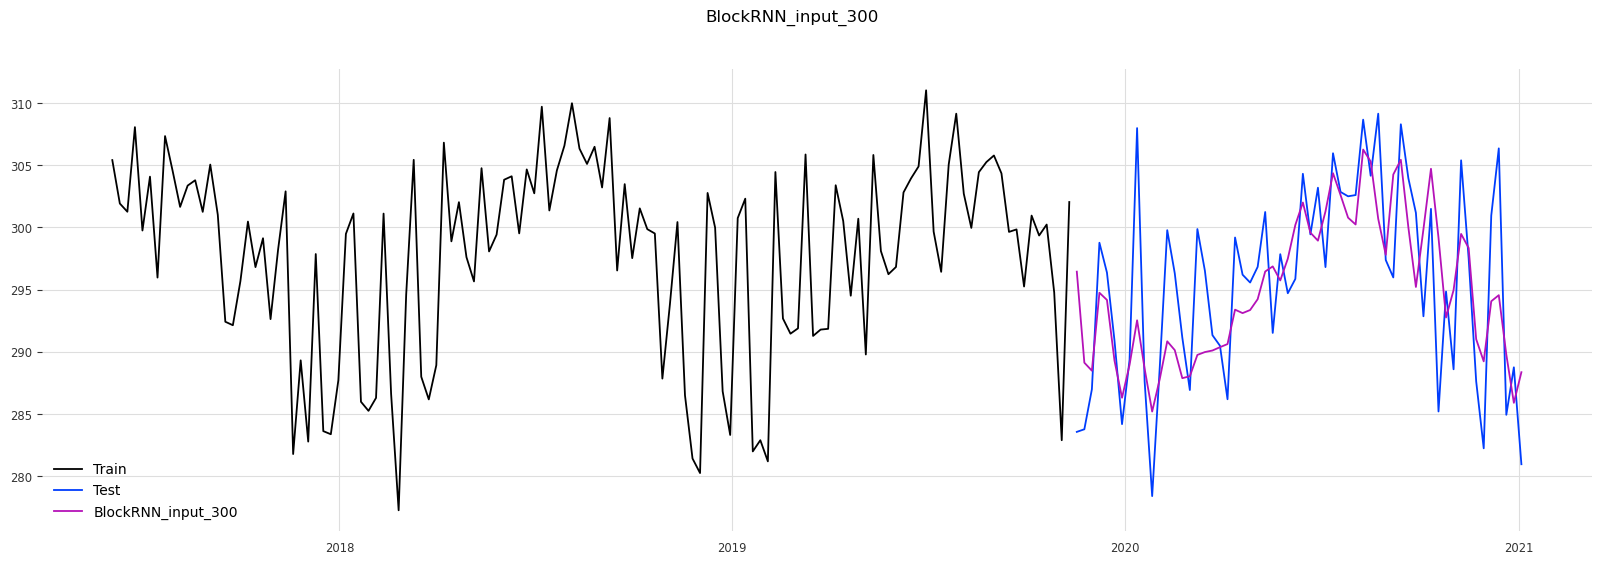

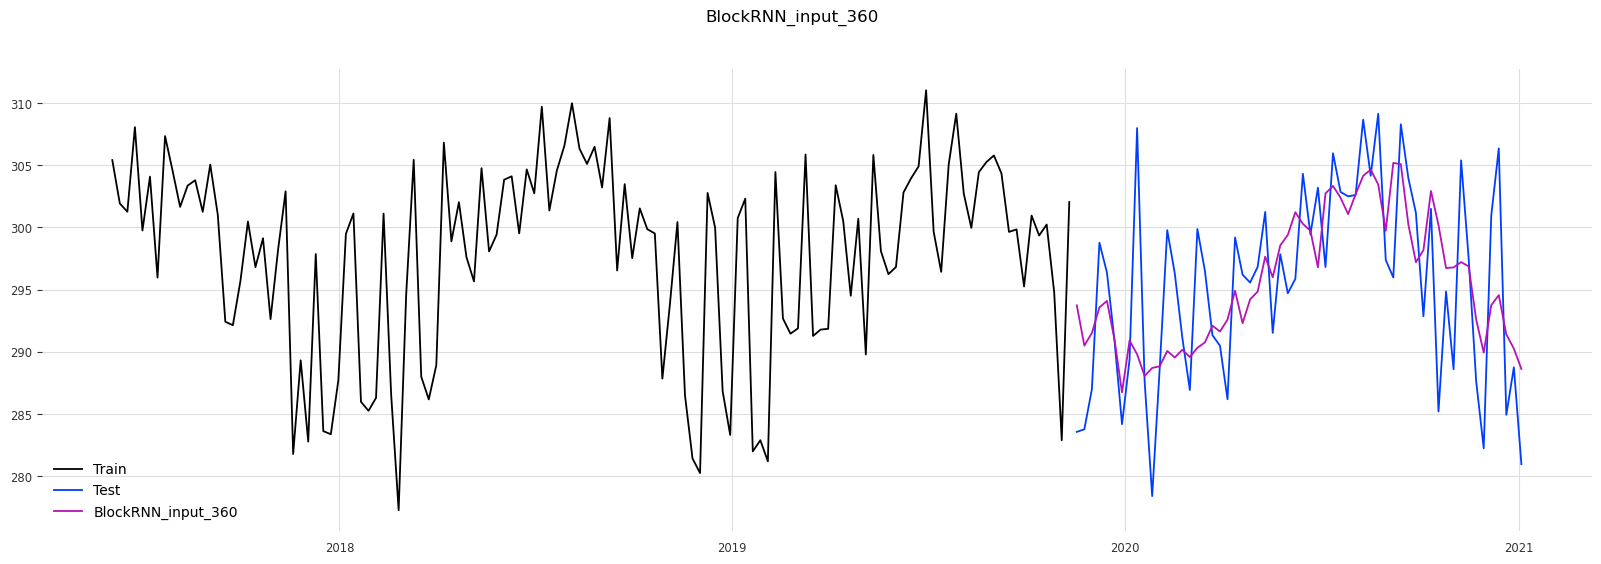

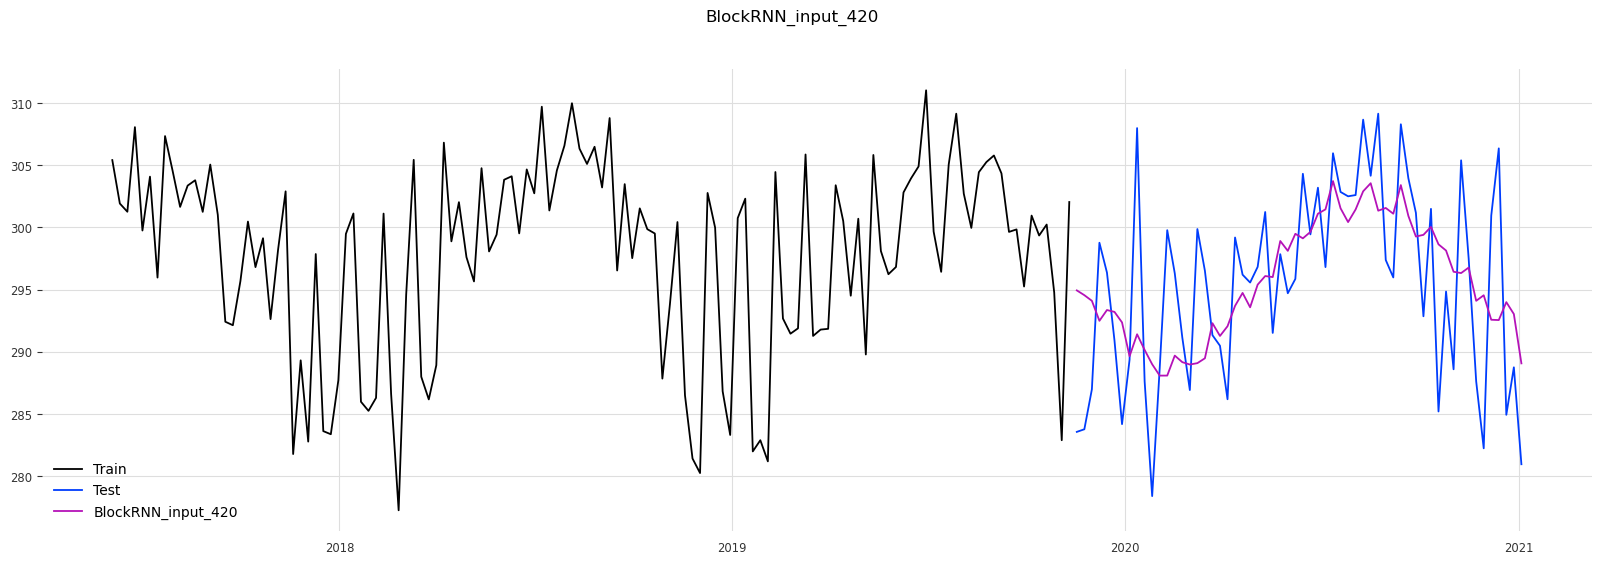

In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model_list = list(test_multi_plot.columns)
model_list.remove("Tpot (K)")
# Plot results
for model_name in model_list:  
    plt.figure(figsize=(20, 6))
    plot_title = model_name
    plt.plot(train_multi_plot[-128:], label='Train')
    plt.plot(test_multi_plot['Tpot (K)'], label='Test')
    plt.plot(test_multi_plot[model_name], label=plot_title)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.legend(loc='best')
    plt.suptitle(plot_title) # add a title
    plt.savefig("{}.png".format(plot_title.replace("/", " per ").replace("**", "^"))) # save the figure
    plt.show(block = False)